<a href="https://colab.research.google.com/github/kaarthikalagappan/ai_course_projects/blob/master/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning MobileNetV2 (Adapted from Dr. Wocjan's notebook)

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [20]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-19 23:14:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  92.9MB/s    in 0.7s    

2020-04-19 23:14:32 (92.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with MobileNetV2 convolution base and custom densely connected layers

### Load the convolutional base

In [23]:
from keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8192256   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 10,450,497
Trainable params: 8,192,513
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [27]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 20s 203ms/step - loss: 0.4422 - acc: 0.7900 - val_loss: 0.0997 - val_acc: 0.9150
Epoch 2/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3223 - acc: 0.8650 - val_loss: 0.1298 - val_acc: 0.9440
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.2974 - acc: 0.8745 - val_loss: 0.1014 - val_acc: 0.9230
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.2761 - acc: 0.8875 - val_loss: 0.0869 - val_acc: 0.9300
Epoch 5/30
100/100 [==============================] - 17s 172ms/step - loss: 0.2798 - acc: 0.8805 - val_loss: 0.5950 - val_acc: 0.8960
Epoch 6/30
100/100 [==============================] - 17s 171ms/step - loss: 0.2495 - acc: 0.8895 - val_loss: 0.0017 - val_acc: 0.9260
Epoch 7/30
100/100 [==============================] - 17s 170ms/step - loss: 0.2540 - acc: 0.8920 - val_lo

## Display curves of loss and accuracy during training

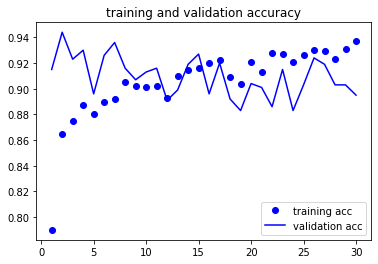

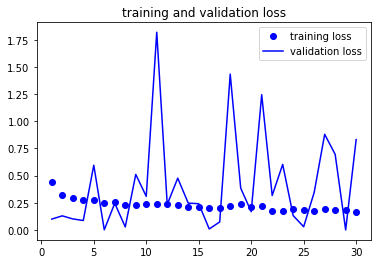

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [29]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
#   print(layer.name)
  if layer.name == 'block_16_expand':
    print("yes")
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

yes


In [30]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 222ms/step - loss: 0.1637 - acc: 0.9340 - val_loss: 0.0555 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 18s 179ms/step - loss: 0.1737 - acc: 0.9350 - val_loss: 0.5623 - val_acc: 0.9400
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 0.1527 - acc: 0.9435 - val_loss: 0.2195 - val_acc: 0.9330
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1480 - acc: 0.9400 - val_loss: 0.3150 - val_acc: 0.9490
Epoch 5/100
100/100 [==============================] - 18s 178ms/step - loss: 0.1625 - acc: 0.9360 - val_loss: 0.0224 - val_acc: 0.9550
Epoch 6/100
100/100 [==============================] - 18s 178ms/step - loss: 0.1514 - acc: 0.9415 - val_loss: 0.1440 - val_acc: 0.9560
Epoch 7/100
100/100 [==============================] - 18s 181ms/step - loss: 0.1586 - acc: 0.9375 - val_loss: 0.0142 - val_acc: 0.9570
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

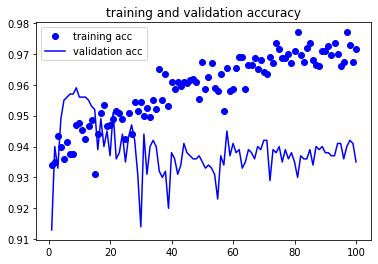

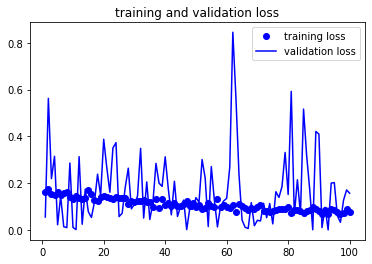

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

After unfreezing different set of layers, I ended up stick it with this model as it was least overfitting from my experiments

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [33]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.15727001428604126
Validation accuracy: 0.9350000023841858


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
#Caused error
# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)